I downloaded the Men's Basketball dataset from http://opensourcesports.com/files/basketball/BasketballDB-20130121.zip. The Men’s Basketball Database contains individual and team statistics from professional basketball leagues including the National Basketball Association through the 2011-12 NBA season.

Let's start with some Exploratory Data Analysis to see what we are working with

In [51]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier

In [52]:
#Load in the player data
path = "./data/basketball_master.csv"
players = pd.read_csv(path, header=0)
players.head()
players.drop(0, axis=0, inplace=True) #unnecessary header row

In [53]:
players.columns

Index([u'bioID', u'useFirst', u'firstName', u'middleName', u'lastName',
       u'nameGiven', u'fullGivenName', u'nameSuffix', u'nameNick', u'pos',
       u'firstseason', u'lastseason', u'height', u'weight', u'college',
       u'collegeOther', u'birthDate', u'birthCity', u'birthState',
       u'birthCountry', u'highSchool', u'hsCity', u'hsState', u'hsCountry',
       u'deathDate', u'race'],
      dtype='object')

In [54]:
players.shape
#5061 players - that seems about right for professionals

(5061, 26)

In [55]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5061 entries, 1 to 5061
Data columns (total 26 columns):
bioID            5061 non-null object
useFirst         4230 non-null object
firstName        5037 non-null object
middleName       3245 non-null object
lastName         5061 non-null object
nameGiven        9 non-null object
fullGivenName    26 non-null object
nameSuffix       323 non-null object
nameNick         2707 non-null object
pos              4879 non-null object
firstseason      5046 non-null float64
lastseason       5046 non-null float64
height           5048 non-null float64
weight           5047 non-null float64
college          4883 non-null object
collegeOther     853 non-null object
birthDate        5050 non-null object
birthCity        3887 non-null object
birthState       3607 non-null object
birthCountry     3901 non-null object
highSchool       4288 non-null object
hsCity           4296 non-null object
hsState          4227 non-null object
hsCountry        4296 

For fun let's play around with the demographic data before digging into the statistics

In [56]:
#What do player heights look like?
peac = players[players.height>0]
object_columns = ["pos", "height"]
peac = peac[object_columns]
peac.dropna(axis=0,inplace=True)

In [57]:
#Map dictionary onto the position column to simplify it.
pos_dict = {'F-C':"front", 'C':"front", 'G':"back", 'G-F':"back", 'C-F':"front", 'F':"front", 'F-G':"front", 
            'F-G-C':"front", 'F-G-C':"front", 'C-F-G':"front", 'C-G': "front", 'G-F-C':"back", ' G':"front"}
peac["pos"] = peac.pos.map(pos_dict)


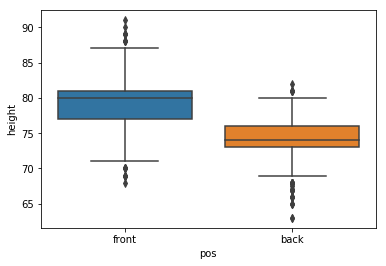

In [58]:
#Boxplot
sns.boxplot(x= "pos", y = "height", data = peac);
#the front court seems to be half a foot taller - that makes sense

In [59]:
players.firstseason.value_counts()
#not very useful

0.0       5045
1951.0       1
Name: firstseason, dtype: int64

In [60]:
players.race.value_counts()
#almost evenly split by race - interesting and unexpected based on watching the game

B    2460
W    2431
O       9
1       2
Name: race, dtype: int64

In [61]:
#Limit data to recent players
peac = players[players.birthDate>'1980-01-01']

In [62]:
#Simplify the dataset
object_columns = ["race", "birthCountry"]
peac = peac[object_columns]
peac = peac[peac.race.isin(["B", "W"])]

#Simplify the Birth Countries
peac.birthCountry = peac.birthCountry.apply(lambda x: "USA" if x == "USA" else "WORLD")

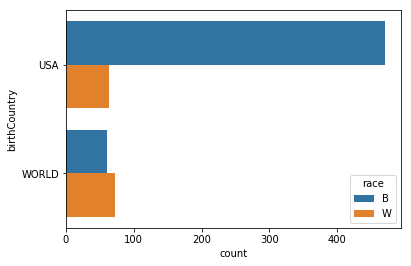

In [63]:
sns.countplot(y = "birthCountry", hue="race", order=["USA", "WORLD"], data= peac);

While the USA players are predominantly black, world players are mostly white

OK finally time to dig into the stats

In [64]:
#Load in the player stats data
path = "./data/basketball_players.csv"
stats = pd.read_csv(path, header=0)
stats.head()

,playerID,year,stint,tmID,lgID,GP,GS,minutes,points,oRebounds,...,PostBlocks,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,note
0,abramjo01,1946,1,PIT,NBA,47,0,0,527,0,...,0,0,0,0,0,0,0,0,0,NaN
1,aubucch01,1946,1,DTF,NBA,30,0,0,65,0,...,0,0,0,0,0,0,0,0,0,NaN
2,bakerno01,1946,1,CHS,NBA,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,baltihe01,1946,1,STB,NBA,58,0,0,138,0,...,0,0,3,10,2,1,0,0,0,NaN
4,barrjo01,1946,1,STB,NBA,58,0,0,295,0,...,0,0,0,0,0,0,0,0,0,NaN


In [65]:
#Over 40 features - we'll want to engineer them to find the relevant ones
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23751 entries, 0 to 23750
Data columns (total 42 columns):
playerID              23751 non-null object
year                  23751 non-null int64
stint                 23751 non-null int64
tmID                  23751 non-null object
lgID                  23751 non-null object
GP                    23751 non-null int64
GS                    23751 non-null int64
minutes               23751 non-null int64
points                23751 non-null int64
oRebounds             23751 non-null int64
dRebounds             23751 non-null int64
rebounds              23751 non-null int64
assists               23751 non-null int64
steals                23751 non-null int64
blocks                23751 non-null int64
turnovers             23751 non-null int64
PF                    23751 non-null int64
fgAttempted           23751 non-null int64
fgMade                23751 non-null int64
ftAttempted           23751 non-null int64
ftMade                23751 

In [66]:
#First let's remove all Postseason specific stats because awards are based on regular season stats and voting
object_columns = ["playerID","year","stint","tmID","lgID","GP","GS","minutes","points","oRebounds","dRebounds","rebounds","assists","steals","blocks","turnovers","PF","fgAttempted","fgMade","ftAttempted","ftMade","threeAttempted","threeMade"]
steac = stats[object_columns]
steac.head()

,playerID,year,stint,tmID,lgID,GP,GS,minutes,points,oRebounds,...,steals,blocks,turnovers,PF,fgAttempted,fgMade,ftAttempted,ftMade,threeAttempted,threeMade
0,abramjo01,1946,1,PIT,NBA,47,0,0,527,0,...,0,0,0,161,834,202,178,123,0,0
1,aubucch01,1946,1,DTF,NBA,30,0,0,65,0,...,0,0,0,46,91,23,35,19,0,0
2,bakerno01,1946,1,CHS,NBA,4,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,baltihe01,1946,1,STB,NBA,58,0,0,138,0,...,0,0,0,98,263,53,69,32,0,0
4,barrjo01,1946,1,STB,NBA,58,0,0,295,0,...,0,0,0,164,438,124,79,47,0,0


In [67]:
steac.groupby(steac.stint).size()

stint
0     1716
1    19672
2     2197
3      157
4        8
5        1
dtype: int64

In [68]:
#Many of these features will be correlated - such as dRebounds and Total Rebounds
steac.corr()

,year,stint,GP,GS,minutes,points,oRebounds,dRebounds,rebounds,assists,steals,blocks,turnovers,PF,fgAttempted,fgMade,ftAttempted,ftMade,threeAttempted,threeMade
year,1.000000,0.321196,0.151644,0.185745,0.204921,0.075553,0.260776,0.322403,0.085439,0.103975,0.341994,0.251068,0.335111,0.051116,0.073412,0.073880,0.000828,0.006701,0.355644,0.341155
stint,0.321196,1.000000,-0.029288,0.001627,0.020257,-0.020637,0.025129,0.022830,0.014150,0.015189,0.017545,0.008014,0.028030,-0.007552,0.017789,-0.015381,-0.023117,-0.026340,0.009423,0.008670
GP,0.151644,-0.029288,1.000000,0.069570,0.841796,0.744425,0.551357,0.585821,0.678836,0.616703,0.577467,0.401818,0.590895,0.876721,0.757345,0.748999,0.677645,0.662767,0.321263,0.303655
GS,0.185745,0.001627,0.069570,1.000000,0.102986,0.086736,0.069774,0.120813,0.069506,0.072789,0.099738,0.083776,0.105457,0.043571,0.081443,0.082655,0.059663,0.062941,0.156200,0.151737
minutes,0.204921,0.020257,0.841796,0.102986,1.000000,0.908447,0.620917,0.694882,0.807392,0.756139,0.677764,0.453175,0.712813,0.858355,0.911889,0.910663,0.822079,0.818180,0.410858,0.390123
points,0.075553,-0.020637,0.744425,0.086736,0.908447,1.000000,0.551717,0.617656,0.744812,0.719260,0.610388,0.390362,0.685989,0.789736,0.980876,0.993470,0.931516,0.937151,0.385828,0.367896
oRebounds,0.260776,0.025129,0.551357,0.069774,0.620917,0.551717,1.000000,0.912198,0.717322,0.272207,0.546973,0.690017,0.666478,0.625929,0.517172,0.567413,0.522428,0.489200,0.084645,0.070332
dRebounds,0.322403,0.022830,0.585821,0.120813,0.694882,0.617656,0.912198,1.000000,0.741233,0.386010,0.624603,0.727634,0.729854,0.641263,0.585404,0.626991,0.557674,0.537308,0.255374,0.238211
rebounds,0.085439,0.014150,0.678836,0.069506,0.807392,0.744812,0.717322,0.741233,1.000000,0.427635,0.401763,0.553483,0.506636,0.793851,0.735951,0.753673,0.750967,0.705969,0.102585,0.092112
assists,0.103975,0.015189,0.616703,0.072789,0.756139,0.719260,0.272207,0.386010,0.427635,1.000000,0.678578,0.154936,0.637256,0.582330,0.728136,0.710719,0.641102,0.661432,0.410797,0.383373


In [94]:
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': '.8',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': 'w',
 'axes.linewidth': 1.0,
 'figure.facecolor': 'white',
 'font.family': [u'sans-serif'],
 'font.sans-serif': [u'Arial',
  u'DejaVu Sans',
  u'Liberation Sans',
  u'Bitstream Vera Sans',
  u'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': u'-',
 'image.cmap': u'rocket',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': u'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': u'out',
 'xtick.major.size': 0.0,
 'xtick.minor.size': 0.0,
 'ytick.color': '.15',
 'ytick.direction': u'out',
 'ytick.major.size': 0.0,
 'ytick.minor.size': 0.0}

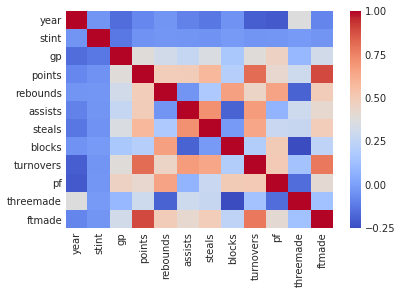

In [97]:
sns.set_style("whitegrid", {"axes.labelcolor": "w"})
sns.heatmap(steac.corr(), cmap="coolwarm")

In [70]:
#Let's further reduce the features
object_columns = ["playerID","year","stint","tmID","GP","GS", "points","rebounds","assists","steals","blocks","turnovers","PF","threeMade", "ftMade"]
steac = stats[object_columns]
steac.head()

,playerID,year,stint,tmID,GP,GS,points,rebounds,assists,steals,blocks,turnovers,PF,threeMade,ftMade
0,abramjo01,1946,1,PIT,47,0,527,0,35,0,0,0,161,0,123
1,aubucch01,1946,1,DTF,30,0,65,0,20,0,0,0,46,0,19
2,bakerno01,1946,1,CHS,4,0,0,0,0,0,0,0,0,0,0
3,baltihe01,1946,1,STB,58,0,138,0,16,0,0,0,98,0,32
4,barrjo01,1946,1,STB,58,0,295,0,54,0,0,0,164,0,47


In [71]:
#OK now let's reign in the scope of the rows of the dataset
#Let's focus on NBA seasons after 1979 when the 3 pointer was introduced and Bird/Magic entered the league - a milestone in the creation of the popular modern period
steac = steac[steac.year>1978]

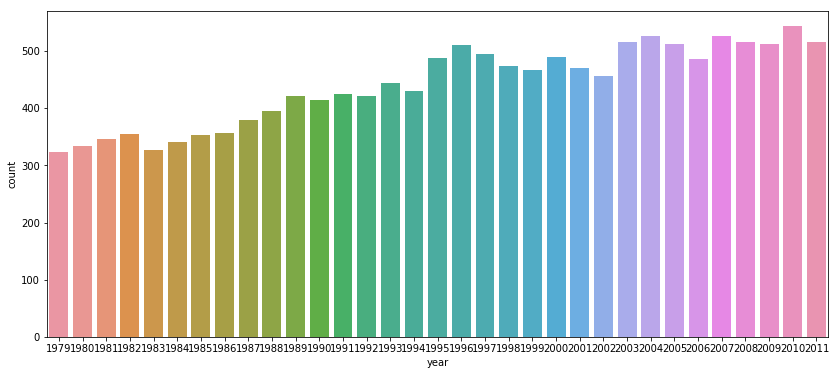

In [72]:
plt.figure(figsize=(14,6))
sns.countplot(x = "year", data= steac);
#looks like we have data for most players in each year

In [73]:
steac.shape

(14581, 15)

In [74]:
#Now we want to focus on players who played most of the year (e.g. weren't injured, relegated)
steac.groupby("GS")["playerID"].count()
#but it looks like the Games Started data is incomplete because almost all values are 0 - I would expect approximately 150 starters per season.

GS
0     13824
1        69
2        42
3        26
4        17
5        22
6        23
7        23
8        14
9        25
10       12
11       15
12       15
13       13
14       13
15        9
16        9
17        8
18        9
19        8
20        4
21        8
22       10
23        8
24        4
25       10
26        4
27        8
28       10
29        8
      ...  
53        8
54       11
55       10
56        6
57        5
58        3
59        3
60        8
61        8
62       15
63        9
64        7
65       10
66       19
67        3
68        1
69        4
70        2
71        2
72        2
73        4
74        4
75        4
76        4
77        3
78        5
79        5
80        8
81        9
82       15
Name: playerID, Length: 83, dtype: int64

In [75]:
#Maybe Games Played data is better
steac.groupby("GP")["playerID"].count()

GP
0        4
1      179
2      215
3      228
4      212
5      187
6      180
7      162
8      155
9      132
10     148
11     147
12     109
13     126
14     121
15     117
16     124
17     110
18     123
19     111
20      96
21     134
22     120
23     137
24     135
25     120
26     122
27     135
28     141
29     124
      ... 
53     128
54     134
55     137
56     139
57     120
58     119
59     126
60     126
61     133
62     153
63     150
64     156
65     185
66     175
67     186
68     163
69     157
70     208
71     191
72     231
73     198
74     242
75     295
76     275
77     294
78     340
79     430
80     570
81     616
82    1300
Name: playerID, Length: 83, dtype: int64

In [76]:
#Let's focus on players who have played most of the season
steac.drop("GS", axis=1, inplace=True)
steac = steac[steac.GP>60]
steac.shape
#6648 

(6648, 14)

In [77]:
steac.columns = steac.columns.str.lower()
steac.isnull().sum()

playerid     0
year         0
stint        0
tmid         0
gp           0
points       0
rebounds     0
assists      0
steals       0
blocks       0
turnovers    0
pf           0
threemade    0
ftmade       0
dtype: int64

OK so this dataset now looks like a straightforward box score for over 20 seasons.
We should add a few more features including the target classifiers.

In [78]:
#Load in the award data
path = "./data/basketball_awards_players.csv"
awards = pd.read_csv(path, header=0)
awards.head()


,playerID,award,year,lgID,note,pos
0,feeribo01,All-NBA First Team,1946,NBA,NaN,NaN
1,fulksjo01,All-NBA First Team,1946,NBA,NaN,NaN
2,mckinho01,All-NBA First Team,1946,NBA,NaN,NaN
3,miasest01,All-NBA First Team,1946,NBA,NaN,NaN
4,zasloma01,All-NBA First Team,1946,NBA,NaN,NaN


In [79]:
#Use pd.get_dummies to make dummy variables from the award column
aw_dums = pd.get_dummies(awards.award, prefix = "aw")
aw_dums.head()

,aw_All-ABA First Team,aw_All-ABA Second Team,aw_All-Defensive First Team,aw_All-Defensive Second Team,aw_All-Defensive Team,aw_All-NBA First Team,aw_All-NBA Second Team,aw_All-NBA Third Team,aw_All-Rookie First Team,aw_All-Rookie Second Team,...,aw_Defensive Player of the Year,aw_Executive of the Year,aw_Finals MVP,aw_Finals MVP,aw_J. Walter Kennedy Citizenship Award,aw_Most Improved Player,aw_Most Valuable Player,aw_Rookie of the Year,aw_Sixth Man of the Year,aw_Sportsmanship Award
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
#Drop the award column
awards.drop(["lgID","award"], axis= 1, inplace=True)

#Concatenate the awards and aw_dums dataframe
awards = pd.concat([awards, aw_dums], axis=1)

#View new concatenated dataframe
awards.head()

,playerID,year,note,pos,aw_All-ABA First Team,aw_All-ABA Second Team,aw_All-Defensive First Team,aw_All-Defensive Second Team,aw_All-Defensive Team,aw_All-NBA First Team,...,aw_Defensive Player of the Year,aw_Executive of the Year,aw_Finals MVP,aw_Finals MVP,aw_J. Walter Kennedy Citizenship Award,aw_Most Improved Player,aw_Most Valuable Player,aw_Rookie of the Year,aw_Sixth Man of the Year,aw_Sportsmanship Award
0,feeribo01,1946,NaN,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,fulksjo01,1946,NaN,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,mckinho01,1946,NaN,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,miasest01,1946,NaN,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,zasloma01,1946,NaN,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [81]:
#Clean up the awards data a bit
awards.columns = awards.columns.str.lower().str.replace(" ", "_").str.replace("-", "_").str.replace(".", "")
awards.drop(["aw_j_walter_kennedy_citizenship_award", "aw_finals_mvp", "aw_finals_mvp_", "aw_executive_of_the_year", "aw_all_aba_first_team", "aw_all_aba_second_team"], axis=1, inplace=True)
awards.columns

Index([u'playerid', u'year', u'note', u'pos', u'aw_all_defensive_first_team',
       u'aw_all_defensive_second_team', u'aw_all_defensive_team',
       u'aw_all_nba_first_team', u'aw_all_nba_second_team',
       u'aw_all_nba_third_team', u'aw_all_rookie_first_team',
       u'aw_all_rookie_second_team', u'aw_comeback',
       u'aw_defensive_player_of_the_year', u'aw_most_improved_player',
       u'aw_most_valuable_player', u'aw_rookie_of_the_year',
       u'aw_sixth_man_of_the_year', u'aw_sportsmanship_award'],
      dtype='object')

In [82]:
#Let's start by using All NBA First Team as our target
firstteam = awards[awards.aw_all_nba_first_team>0]
object_columns = ["playerid", "year", "aw_all_nba_first_team"]
firstteam = firstteam[object_columns]
df = pd.merge(left=steac,right=firstteam, how="left", left_on=["playerid", "year"], right_on=["playerid", "year"])
df.rename(columns = {"aw_all_nba_first_team":"target"}, inplace = True)
df.target.fillna(value=0, inplace=True)

#Who are our top players?
df[df.target>0].sort_values("year", ascending=False).head(20)
#That looks correct

,playerid,year,stint,tmid,gp,points,rebounds,assists,steals,blocks,turnovers,pf,threemade,ftmade,target
6366,duranke01,2011,1,OKC,66,1850,527,231,88,77,248,133,133,431,1.0
6343,jamesle01,2011,1,MIA,62,1683,492,387,115,50,213,96,54,387,1.0
6571,bryanko01,2010,1,LAL,82,2078,419,388,99,12,243,172,115,483,1.0
6549,duranke01,2010,1,OKC,78,2161,533,214,88,76,218,159,145,594,1.0
6511,howardw01,2010,1,ORL,78,1784,1098,107,107,186,279,258,0,546,1.0
6505,jamesle01,2010,1,MIA,79,2111,590,554,124,50,284,163,92,503,1.0
6447,rosede01,2010,1,CHI,81,2026,330,623,85,51,278,136,128,476,1.0
6159,duranke01,2009,1,OKC,82,2472,623,231,112,84,271,171,128,756,1.0
6128,bryanko01,2009,1,LAL,73,1970,391,365,113,20,233,187,99,439,1.0
6203,howardw01,2009,1,ORL,82,1503,1082,144,75,228,274,287,0,483,1.0


In [83]:
#The player's team isn't informative, but perhaps the team's success is 
#Load in the team data
path = "./data/basketball_teams.csv"
teams = pd.read_csv(path, header=0)
object_columns = ["tmID", "year", "won"]
teams = teams[object_columns]
df = pd.merge(left=df,right=teams, how="left", left_on=["tmid", "year"], right_on=["tmID", "year"])
df.drop(["tmid", "tmID"], axis=1, inplace=True)
df.rename(columns = {"won":"teamwins"}, inplace = True)
df[df.target>0].sort_values("year", ascending=False).head(20)


,playerid,year,stint,gp,points,rebounds,assists,steals,blocks,turnovers,pf,threemade,ftmade,target,teamwins
6366,duranke01,2011,1,66,1850,527,231,88,77,248,133,133,431,1.0,47.0
6343,jamesle01,2011,1,62,1683,492,387,115,50,213,96,54,387,1.0,46.0
6571,bryanko01,2010,1,82,2078,419,388,99,12,243,172,115,483,1.0,57.0
6549,duranke01,2010,1,78,2161,533,214,88,76,218,159,145,594,1.0,55.0
6511,howardw01,2010,1,78,1784,1098,107,107,186,279,258,0,546,1.0,52.0
6505,jamesle01,2010,1,79,2111,590,554,124,50,284,163,92,503,1.0,58.0
6447,rosede01,2010,1,81,2026,330,623,85,51,278,136,128,476,1.0,62.0
6159,duranke01,2009,1,82,2472,623,231,112,84,271,171,128,756,1.0,50.0
6128,bryanko01,2009,1,73,1970,391,365,113,20,233,187,99,439,1.0,57.0
6203,howardw01,2009,1,82,1503,1082,144,75,228,274,287,0,483,1.0,59.0


In [84]:
df[(df.teamwins.isnull()) & (df.year==2007)]["teamwins"] = "32"
df[(df.teamwins.isnull()) & (df.year==2008)].teamwins = "35"
df[(df.teamwins.isnull()) & (df.year==2009)].teamwins = "44"
#*** this is isn't working so for now drop these insignificant rows
df.dropna(inplace=True)
df.isnull().sum()

/home/villager/Programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


playerid     0
year         0
stint        0
gp           0
points       0
rebounds     0
assists      0
steals       0
blocks       0
turnovers    0
pf           0
threemade    0
ftmade       0
target       0
teamwins     0
dtype: int64

In [85]:
#Game averages are more informative than total points
df["points"] = (df["points"] / df["gp"])
df["rebounds"] = (df["rebounds"] / df["gp"])
df["assists"] = (df["assists"] / df["gp"])
df["steals"] = (df["steals"] / df["gp"])
df["blocks"] = (df["blocks"] / df["gp"])
df["turnovers"] = (df["turnovers"] / df["gp"])
df["pf"] = (df["pf"] / df["gp"])
df["threemade"] = (df["threemade"] / df["gp"])
df["ftmade"] = (df["ftmade"] / df["gp"])
df["teamwins"] = (df["teamwins"] / 82)

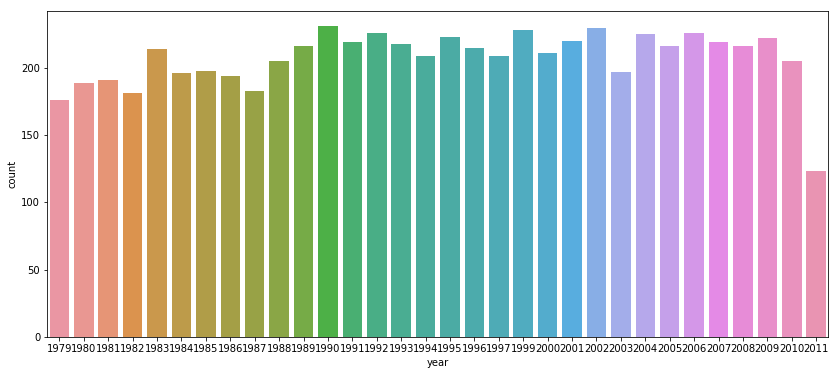

In [87]:
plt.figure(figsize=(14,6))
sns.countplot(x = "year", data= df);
#looks like we have data for most players in each year

In [101]:
#Averages of box stats for new dataset
df.groupby("year")["points", "assists", "rebounds", "blocks"].mean()

,points,assists,rebounds,blocks
year,,,,
1979,11.948940,2.855837,4.831623,0.576839
1980,12.130480,2.769704,4.875831,0.589756
1981,11.675037,2.775919,4.628292,0.582648
1982,12.040161,2.885045,4.757205,0.616503
1983,11.707410,2.724729,4.510759,0.559806
1984,11.952288,2.874055,4.666514,0.588891
1985,11.875892,2.792696,4.626172,0.559127
1986,11.883467,2.796765,4.758620,0.607731
1987,11.877372,2.800290,4.731322,0.574018


In [ ]:
#Averages of box stats for new dataset
df.groupby("year")["points", "assists", "rebounds", "blocks"].mean()

In [114]:
#Top scorers of each year
df.sort_values(by="points", axis=0, ascending=False).groupby("year").head(2).sort_values(by="year")

,playerid,year,stint,gp,points,rebounds,assists,steals,blocks,turnovers,pf,threemade,ftmade,target,teamwins
59,gervige01,1979,1,78,33.141026,5.166667,2.589744,1.410256,1.012821,3.256410,2.666667,0.410256,6.474359,1.0,0.500000
55,freewo01,1979,1,68,30.220588,3.500000,4.161765,1.191176,0.470588,3.352941,2.867647,0.132353,8.411765,0.0,0.426829
290,malonmo01,1980,1,80,27.775000,14.750000,1.762500,1.037500,1.875000,3.850000,2.787500,0.012500,7.612500,0.0,0.487805
209,dantlad01,1980,1,80,30.650000,6.362500,4.025000,1.362500,0.225000,3.525000,3.062500,0.025000,7.900000,0.0,0.341463
421,gervige01,1981,1,79,32.291139,4.962025,2.367089,0.974684,0.569620,2.658228,2.721519,0.126582,7.025316,1.0,0.585366
476,malonmo01,1981,1,81,31.111111,14.666667,1.753086,0.938272,1.543210,3.629630,2.567901,0.000000,7.777778,1.0,0.560976
715,vandeki01,1982,1,82,26.658537,5.329268,2.475610,0.804878,0.463415,2.158537,2.414634,0.182927,5.963415,0.0,0.548780
608,englial01,1982,1,82,28.365854,7.329268,4.841463,1.414634,1.536585,3.207317,2.865854,0.024390,4.951220,0.0,0.548780
739,aguirma01,1983,1,79,29.493671,5.936709,4.531646,1.012658,0.278481,3.607595,3.113924,0.189873,5.886076,0.0,0.524390
775,dantlad01,1983,1,79,30.607595,5.670886,3.924051,0.772152,0.050633,3.329114,2.544304,0.012658,10.291139,0.0,0.548780


In [178]:
#Top scorers of each year
topscorers = df.sort_values(by="points", axis=0, ascending=False).groupby("year").head(20)
toppoints = topscorers.groupby("year").points.mean()
toppoints.mean()

23.36564716382145

In [179]:
#Top rebounders of each year
toprebounders = df.sort_values(by="rebounds", axis=0, ascending=False).groupby("year").head(20)
toprebounds = toprebounders.groupby("year").rebounds.mean()
toprebounds.mean()

10.363495035868453

In [180]:
#Top assisters of each year
topassisters = df.sort_values(by="assists", axis=0, ascending=False).groupby("year").head(20)
topassists = topassisters.groupby("year").assists.mean()
topassists.mean()

7.411977267616864

In [182]:
#Top blockers of each year
topblockers = df.sort_values(by="blocks", axis=0, ascending=False).groupby("year").head(20)
topblocks = topblockers.groupby("year").blocks.mean()
topblocks.mean()

2.046345801646967

In [183]:
#Top stealers of each year
topstealers = df.sort_values(by="assists", axis=0, ascending=False).groupby("year").head(20)
topsteals = topstealers.groupby("year").steals.mean()
topsteals.mean()

1.5893189144345876

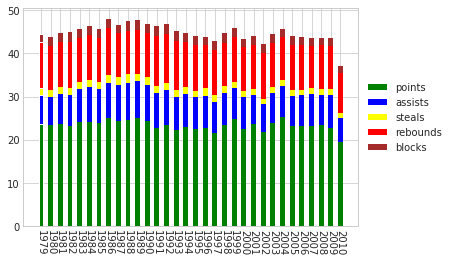

In [175]:
# Values of each group
bars1 = toppoints
bars2 = topassists
bars3 = topsteals
bars4 = toprebounds
bars5 = topblocks
 
# The position of the bars on the x-axis
r = range(0, 32*4, 4)
 
# Names of group and bar width
names = range(1979, 2012)
barWidth = 2
 
# Create bars
plt.bar(r, bars1, color='green', edgecolor='white', width=barWidth, label="points")
plt.bar(r, bars2, bottom=bars1, color='blue', edgecolor='white', width=barWidth, label="assists")
plt.bar(r, bars3, bottom=bars1+bars2, color='yellow', edgecolor='white', width=barWidth, label="steals")
plt.bar(r, bars4, bottom=bars1+bars2+bars3, color='red', edgecolor='white', width=barWidth, label="rebounds")
plt.bar(r, bars5, bottom=bars1+bars2+bars3+bars4, color='brown', edgecolor='white', width=barWidth, label="blocks")

# Custom X axis
plt.xticks(r, names)
#plt.xlabel(names)
plt.xticks(rotation=270)
 
# Show graphic
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [184]:
#Also need to set up data frame to only have numeric values
#df["season"] = df["playerid"] + "_" + df["year"].map(str)
df2 = df.copy()
df2.drop(["playerid", "year", "stint"], axis=1, inplace=True)
#not sure how stint is used - maybe for trades?

In [185]:
df2.shape

(6631, 12)

In [194]:
(df2.target==0).sum()

6477

Finally time to do some machine learning

In [186]:
df2.target.value_counts(normalize=True)
#It's a skewed dataset - we may want to revisit and adjust

0.0    0.976776
1.0    0.023224
Name: target, dtype: float64

In [738]:
X = df2.drop("target", axis =1)
y = df2.target

X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = .25)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_train, y_train)

#must be overfit

1.0

In [739]:
#Evaluate the model on the test set
dt.score(X_test, y_test)
#slightly better than null accuracy of 0.9768

0.97889022919179736

In [745]:
cv_scores = cross_val_score(DecisionTreeClassifier(), X, y, cv = 5, scoring = "accuracy")
cv_scores.mean()
#very close to the accuracy score above using cv=5: 0.97889

0.97949035739278345

We can upsample to deal with the target imbalance

In [187]:
target_maj = df2[df2.target==0]
target_min = df2[df2.target==1]

# Number non award observations
N = df2.target.value_counts()[0]

# Upsample minority class
target_minority_upsampled = resample(target_min, replace=True, n_samples=N) 
 
# Combine majority class with upsampled minority class
df2_us = pd.concat([target_minority_upsampled, target_maj])
 
# Display new class counts
df2_us.target.value_counts()

0.0    6477
1.0    6477
Name: target, dtype: int64

In [195]:
# Cross Validation
#Assign X and y
X_us = df2_us.drop("target", axis = 1)
y_us = df2_us.target

X_train, X_test, y_train, y_test = train_test_split(X_us ,y_us, test_size = .25)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

score = cross_val_score(DecisionTreeClassifier(), X_us, y_us, cv = 5, scoring="accuracy").mean()
print ("The upsampled accuracy score is {:.4f} percent".format(score*100)) #Better than null accuracy
score = cross_val_score(DecisionTreeClassifier(), X_us, y_us, cv = 5, scoring="precision").mean()
print ("The upsampled precision score is {:.4f} percent".format(score*100)) 
score = cross_val_score(DecisionTreeClassifier(), X_us, y_us, cv = 5, scoring="recall").mean()
print ("The upsampled recall score is {:.4f} percent".format(score*100)) 
score = cross_val_score(DecisionTreeClassifier(), X_us, y_us, cv = 5, scoring="roc_auc").mean()
print ("The upsampled roc_auc score is {:.4f} percent".format(score*100)) 

The upsampled accuracy score is 99.2666 percent
The upsampled precision score is 98.5403 percent
The upsampled recall score is 100.0000 percent
The upsampled roc_auc score is 99.2512 percent


In [197]:
#Confusion Matrix
preds = dt.predict(X_test)
cmat = confusion_matrix(y_test, preds)

In [198]:
cmat

array([[1563,   19],
       [   0, 1657]])

In [200]:
df2_us.head(5)

,gp,points,rebounds,assists,steals,blocks,turnovers,pf,threemade,ftmade,target,teamwins
1455,77,26.077922,9.909091,2.571429,0.493506,2.233766,2.558442,3.116883,0.000000,5.558442,1.0,0.719512
6571,82,25.341463,5.109756,4.731707,1.207317,0.146341,2.963415,2.097561,1.402439,5.890244,1.0,0.695122
5977,81,28.444444,7.567901,7.246914,1.691358,1.148148,2.975309,1.716049,1.629630,7.333333,1.0,0.804878
4319,70,27.114286,11.100000,4.200000,1.328571,1.685714,2.785714,3.228571,0.028571,4.628571,1.0,0.670732
5977,81,28.444444,7.567901,7.246914,1.691358,1.148148,2.975309,1.716049,1.629630,7.333333,1.0,0.804878


Would scaling the data help? Perhaps stats like points are weighted higher (maybe that is a good thing though)

In [202]:
#Intialize scalers
ss = StandardScaler()
mm = MinMaxScaler()

#Fit and transform data using scalers and then make data frames from the scaled data
X_ss = ss.fit_transform(X_us)
X_mm = mm.fit_transform(X_us)
X_ss = pd.DataFrame(X_ss, columns=X_us.columns)
X_mm = pd.DataFrame(X_mm, columns=X_us.columns)

In [203]:
X_ss.head()

,gp,points,rebounds,assists,steals,blocks,turnovers,pf,threemade,ftmade,teamwins
0,0.067523,0.931459,1.001848,-0.474623,-1.148126,1.540193,0.207552,0.875904,-0.815360,0.638377,0.871652
1,0.932871,0.846264,-0.397053,0.259208,-0.046324,-0.839000,0.627595,-0.658619,1.347223,0.776546,0.709533
2,0.759802,1.205224,0.319443,1.113606,0.700817,0.302833,0.639932,-1.232960,1.697555,1.377475,1.439070
3,-1.143964,1.051348,1.348972,0.078591,0.140838,0.915537,0.443282,1.044044,-0.771302,0.251162,0.547413
4,0.759802,1.205224,0.319443,1.113606,0.700817,0.302833,0.639932,-1.232960,1.697555,1.377475,1.439070


In [204]:
X_mm.head()

,gp,points,rebounds,assists,steals,blocks,turnovers,pf,threemade,ftmade,teamwins
0,0.761905,0.695620,0.518381,0.173317,0.123248,0.401686,0.529760,0.626585,0.000000,0.538300,0.800000
1,1.000000,0.675255,0.254198,0.322549,0.320223,0.026316,0.617241,0.396229,0.406655,0.570669,0.769231
2,0.952381,0.761060,0.389509,0.496300,0.453794,0.206465,0.619811,0.310011,0.472532,0.711450,0.907692
3,0.428571,0.724278,0.583935,0.285819,0.353683,0.303133,0.578855,0.651826,0.008285,0.447587,0.738462
4,0.952381,0.761060,0.389509,0.496300,0.453794,0.206465,0.619811,0.310011,0.472532,0.711450,0.907692


In [205]:
# Cross Validation with standard scaled data

score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="accuracy").mean()
print ("The DecisionTree upsampled standard scaled accuracy score is {:.4f} percent".format(score*100)) #Better than null accuracy
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="precision").mean()
print ("The DecisionTree upsampled standard scaled precision score is {:.4f} percent".format(score*100)) 
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="recall").mean()
print ("The DecisionTree upsampled standard scaled recall score is {:.4f} percent".format(score*100)) 
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="roc_auc").mean()
print ("The DecisionTreeupsampled standard scaled roc_auc score is {:.4f} percent".format(score*100)) 

#slightly better for this model, but maybe more for others

The DecisionTree upsampled standard scaled accuracy score is 99.2435 percent
The DecisionTree upsampled standard scaled precision score is 98.5549 percent
The DecisionTree upsampled standard scaled recall score is 100.0000 percent
The DecisionTreeupsampled standard scaled roc_auc score is 99.2280 percent


In [206]:
# Cross Validation with minmax scaled data
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="accuracy").mean()
print ("The DecisionTree upsampled minmax scaled accuracy score is {:.4f} percent".format(score*100)) #Better than null accuracy
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="precision").mean()
print ("The DecisionTree upsampled minmax scaled precision score is {:.4f} percent".format(score*100)) 
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="recall").mean()
print ("The DecisionTree upsampled minmax scaled recall score is {:.4f} percent".format(score*100)) 
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="roc_auc").mean()
print ("The DecisionTree upsampled minmax scaled roc_auc score is {:.4f} percent".format(score*100)) 

#better than z-scores

The DecisionTree upsampled minmax scaled accuracy score is 99.2666 percent
The DecisionTree upsampled minmax scaled precision score is 98.4651 percent
The DecisionTree upsampled minmax scaled recall score is 100.0000 percent
The DecisionTree upsampled minmax scaled roc_auc score is 99.2744 percent


In [210]:
X_train, X_test, y_train, y_test = train_test_split(X_mm ,y_us, test_size = .25)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="accuracy").mean()
print ("The DecisionTree upsampled minmax scaled accuracy score is {:.4f} percent".format(score*100)) #Better than null accuracy
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="precision").mean()
print ("The DecisionTree upsampled minmax scaled precision score is {:.4f} percent".format(score*100)) 
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="recall").mean()
print ("The DecisionTree upsampled minmax scaled recall score is {:.4f} percent".format(score*100)) 
score = cross_val_score(DecisionTreeClassifier(), X_mm, y_us, cv = 5, scoring="roc_auc").mean()
print ("The DecisionTree upsampled minmax scaled roc_auc score is {:.4f} percent".format(score*100)) 

The DecisionTree upsampled minmax scaled accuracy score is 99.2589 percent
The DecisionTree upsampled minmax scaled precision score is 98.5100 percent
The DecisionTree upsampled minmax scaled recall score is 100.0000 percent
The DecisionTree upsampled minmax scaled roc_auc score is 99.2435 percent


In [251]:
#Confusion Matrix
preds = dt.predict(X_test)
cmat = confusion_matrix(y_test, preds)
cmat

array([[1595,   19],
       [   0, 1625]])

TypeError: list indices must be integers, not Series

Let's now model using K-Nearest Neighbors

In [278]:
#intialize model and set n_neighbors equal to 3
knn3 = KNeighborsClassifier(n_neighbors=3)
#Fit the model
knn3.fit(X_us,y_us)
#Find the accuracy score of the model on the data
score3 = float(knn3.score(X_us,y_us))
print "The K3-neighbors model accurately labelled {:.4f} percent of the data".format(score3*100)

#Better than Decision Tree with 99.4442 for X_us
#Even better with 99.5754 with X_mm
#Even better with 99.5831 with X_ss

The K3-neighbors model accurately labelled 99.4442 percent of the data


In [279]:
#Call confusion_matrix 
preds = knn3.predict(X_test)
confusion_matrix(y_test, preds)

array([[1614,    0],
       [1625,    0]])

In [281]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_mm,y_us)
preds = knn3.predict(X_test)
confusion_matrix(y_test, preds)

array([[1601,   13],
       [   0, 1625]])

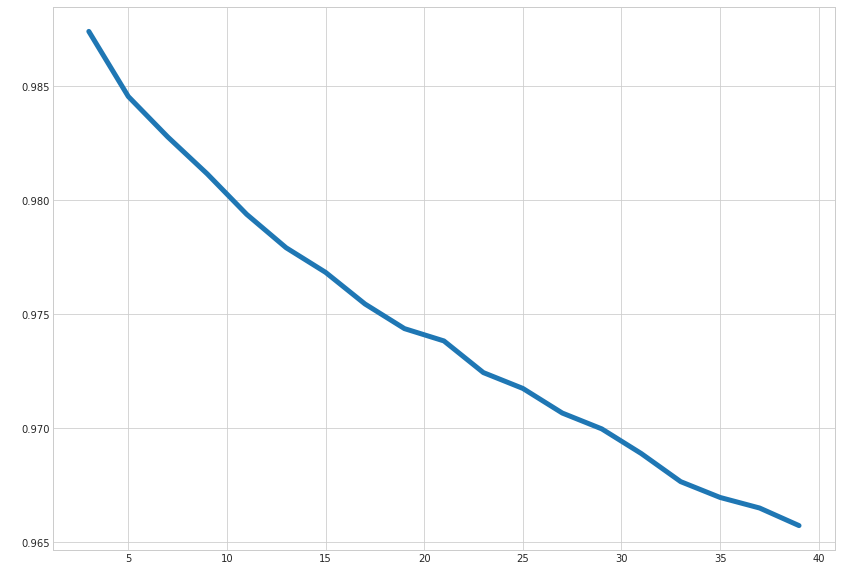

In [283]:
#But what is the optimal number of neighbors?

#Initialize neighbors list
neighbors = range(3, 41, 2)
#Intialize list with cross validated scores
cv_scores = []

for i in neighbors:
    #Fit model with i
    model = KNeighborsClassifier(n_neighbors=i)
    cv_score = cross_val_score(model, X_mm, y_us, cv =5 , scoring="accuracy").mean()
    #Append cv_score to cv_scores
    cv_scores.append(cv_score)
    
    
#Plot line plot of neighbors vs cv_scores
plt.figure(figsize=(14, 10))
plt.plot(neighbors, cv_scores, linewidth = 5)
plt.xlabel("N Neighbors")
plt.ylabel("Cross Validated Accuracy Score")
plt.show()

#Let's stick with 3

In [830]:
#Intialize scalers
ss = StandardScaler()
mm = MinMaxScaler()

#Fit and transform data using scalers and then make data frames from the scaled data
X_ss = ss.fit_transform(X_us)
X_mm = mm.fit_transform(X_us)
X_ss = pd.DataFrame(X_ss, columns=X_us.columns)
X_mm = pd.DataFrame(X_mm, columns=X_us.columns)

In [ ]:
X_ss.head()

In [ ]:
X_mm.head()

In [285]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_mm,y_us)
score3 = float(knn3.score(X_mm,y_us))
print "The K3-neighbors model accurately labelled {:.4f} percent of the data".format(score3*100)


# Cross Validation with standard scaled data

score = cross_val_score(KNeighborsClassifier(3), X_mm, y_us, cv = 5, scoring="accuracy").mean()
print ("The K-neighbors upsampled standard scaled accuracy score is {:.4f} percent".format(score*100))
score = cross_val_score(KNeighborsClassifier(3), X_mm, y_us, cv = 5, scoring="precision").mean()
print ("The K-neighbors upsampled standard scaled precision score is {:.4f} percent".format(score*100)) 
score = cross_val_score(KNeighborsClassifier(3), X_mm, y_us, cv = 5, scoring="recall").mean()
print ("The K-neighbors upsampled standard scaled recall score is {:.4f} percent".format(score*100)) 
score = cross_val_score(KNeighborsClassifier(3), X_mm, y_us, cv = 5, scoring="roc_auc").mean()
print ("The K-neighbors upsampled standard scaled roc_auc score is {:.4f} percent".format(score*100)) 

#Worse

The K3-neighbors model accurately labelled 99.5754 percent of the data
The K-neighbors upsampled standard scaled accuracy score is 98.7418 percent
The K-neighbors upsampled standard scaled precision score is 97.5475 percent
The K-neighbors upsampled standard scaled recall score is 100.0000 percent
The K-neighbors upsampled standard scaled roc_auc score is 99.1200 percent


In [286]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_mm,y_us)
score3 = float(knn3.score(X_mm,y_us))
print "The K3-neighbors model accurately labelled {:.4f} percent of the data".format(score3*100)


# Cross Validation with standard scaled data

score = cross_val_score(KNeighborsClassifier(3), X_us, y_us, cv = 5, scoring="accuracy").mean()
print ("The K-neighbors upsampled standard scaled accuracy score is {:.4f} percent".format(score*100))
score = cross_val_score(KNeighborsClassifier(3), X_us, y_us, cv = 5, scoring="precision").mean()
print ("The K-neighbors upsampled standard scaled precision score is {:.4f} percent".format(score*100)) 
score = cross_val_score(KNeighborsClassifier(3), X_us, y_us, cv = 5, scoring="recall").mean()
print ("The K-neighbors upsampled standard scaled recall score is {:.4f} percent".format(score*100)) 
score = cross_val_score(KNeighborsClassifier(3), X_us, y_us, cv = 5, scoring="roc_auc").mean()
print ("The K-neighbors upsampled standard scaled roc_auc score is {:.4f} percent".format(score*100)) 

#Worse

The K3-neighbors model accurately labelled 99.5754 percent of the data
The K-neighbors upsampled standard scaled accuracy score is 98.6260 percent
The K-neighbors upsampled standard scaled precision score is 97.3263 percent
The K-neighbors upsampled standard scaled recall score is 100.0000 percent
The K-neighbors upsampled standard scaled roc_auc score is 99.0891 percent


In [287]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_ss,y_us)
score3 = float(knn3.score(X_ss,y_us))
print "The K3-neighbors model accurately labelled {:.4f} percent of the data".format(score3*100)


# Cross Validation with standard scaled data

score = cross_val_score(KNeighborsClassifier(3), X_ss, y_us, cv = 5, scoring="accuracy").mean()
print ("The K-neighbors upsampled standard scaled accuracy score is {:.4f} percent".format(score*100))
score = cross_val_score(KNeighborsClassifier(3), X_ss, y_us, cv = 5, scoring="precision").mean()
print ("The K-neighbors upsampled standard scaled precision score is {:.4f} percent".format(score*100)) 
score = cross_val_score(KNeighborsClassifier(3), X_ss, y_us, cv = 5, scoring="recall").mean()
print ("The K-neighbors upsampled standard scaled recall score is {:.4f} percent".format(score*100)) 
score = cross_val_score(KNeighborsClassifier(3), X_ss, y_us, cv = 5, scoring="roc_auc").mean()
print ("The K-neighbors upsampled standard scaled roc_auc score is {:.4f} percent".format(score*100)) 

#Worse

The K3-neighbors model accurately labelled 99.5831 percent of the data
The K-neighbors upsampled standard scaled accuracy score is 98.7418 percent
The K-neighbors upsampled standard scaled precision score is 97.5478 percent
The K-neighbors upsampled standard scaled recall score is 100.0000 percent
The K-neighbors upsampled standard scaled roc_auc score is 99.1586 percent


Now let's model using Logistic Regression

#Make a train test split of the spotify data and train logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33,
                                                    random_state=4)
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

To improve:
Compare positions against each other
Normalize against the season because of changing pace of the league?
Use advanced analytics (PER, Usage, etc.)

Limitations:
All-Star modelling is constrained because stats are only for full season, not by game (to look at midseason stats)